In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensor_PLSA_sparse as tPLSA
import preprocessing as pre
from sklearn.metrics import roc_auc_score

In [2]:
np.random.seed(1)
path2data = "./wiki-RfA.txt"
threshold = 20
ftrain, fvalid, valid, test, user_dic, word2index = pre.prepare_data(path2data, threshold=threshold, return_dicts = True)

In [3]:
ftrain_counts = np.ones(len(ftrain))
valid_srcs, valid_tgts, valid_vots, valid_cmts = valid
test_srcs, test_tgts, test_vots, test_cmts = test

In [4]:
def predict(model, src, tgt, cmt):
    like = np.log(model.p_z+1e-32)
    like += np.log(model.factors[0][src]+1e-32)
    like += np.log(model.factors[1][tgt]+1e-32)
    for word in cmt:
        like += np.log(model.factors[3][word]+1e-32)
    like -= like.max()
    p = np.exp(like)
    p = p.dot(model.factors[2].T)
    p /= p.sum()
    return p

In [5]:
def predict_set(model, srcs, tgts, cmts):
    Ntest = len(srcs)
    ps = np.zeros((Ntest,3))
    for i in range(len(srcs)):
        ps[i] = predict(model, srcs[i], tgts[i], cmts[i])
    return ps

In [6]:
def assess_roc(model, srcs, tgts, vots, cmts):
    ps = predict_set(model, srcs, tgts, cmts)
    pred = np.argmax(ps,axis=1)
    #return roc_auc_score(vots, ps, average = "macro", multi_class='ovo')
    index_binary = [i for i in range(len(vots)) if vots[i] != 1]
    labels = [vots[i]//2 for i in index_binary]
    prob_binary = ps[index_binary][:,[0,2]]
    prob_binary /= prob_binary.sum(axis=1, keepdims=True)
    #print("roc score (including neutral): ", roc_auc_score(indices_test[:,-1], probs, average = "macro", multi_class='ovo'))
    return roc_auc_score(labels, prob_binary[:,1], average = "macro")

In [7]:
ntfmp =  tPLSA.Tensor_PLSA_Sparse(4,n_proc=12)
shape = (11381, 11381, 3, ftrain.max(axis=0)[-1]+1)
ntfmp.initialize_parameter("random", shape)
ntfmp.prepare_fitting()
rocs = []
for i in range(10):
    ntfmp.optimize_once(ftrain, ftrain_counts, True)
    rocs.append(assess_roc(ntfmp, valid_srcs, valid_tgts, valid_vots, valid_cmts))
    if i > 1 and rocs[-1] < rocs[-2] and rocs[-2] < rocs[-3]:
        break
    print(rocs[-1])

0.6119118879746035
0.7710789933593936
0.8420579358424606
0.867143559052957
0.8786729624248989
0.8856998040778118
0.890696493781094
0.8936736506235379
0.8947616307271775
0.8955524805578778


In [44]:
assess_roc(ntfmp, test_srcs, test_tgts, test_vots, test_cmts)

0.9044802623475401

In [8]:
index = 0
line_number = 0
vote_tensor = np.zeros((len(user_dic), len(user_dic), 3))
with open("./wiki-RfA.txt") as file:
    for raw_line in file:
        line = raw_line.rstrip()
        if index == 0:
            src = user_dic[line[4:]]
        if index == 1:
            tgt = user_dic[line[4:]]
        if index == 2:
            vot = int(line[4:])+1
            vote_tensor[src,tgt,vot] += 1
        index += 1
        if index == 8:
            index = 0
        line_number += 1

In [9]:
word_list = [None,]*len(word2index)
for word in word2index:
    word_list[word2index[word]] = word

In [10]:
user_list = [None,]*len(user_dic)
for user in user_dic:
    user_list[user_dic[user]] = user

In [11]:
user_freq = np.sum(ntfmp.factors[0]+ntfmp.factors[1],axis=1)
user_freq /= user_freq.sum()

In [12]:
src_freq = np.sum(ntfmp.factors[0],axis=1)
src_freq /= src_freq.sum()
src_contrasts = ntfmp.factors[0]/(src_freq.reshape(-1,1)+1e-10)

In [13]:
min_freq = 5e-4
min_contrast = 3.5

In [14]:
group = 0
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/vote_tensor[x].sum(), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if src_freq[x] > min_freq and src_contrasts[x,group]>min_contrast]

[['Khoikhoi', 1.9446640316205535, 1.5748792270523795],
 ['Thingg', 1.9672131147540983, 1.685185185184405],
 ['Vilerage', 1.8793103448275863, 0.0],
 ['Candlewicke', 1.9014084507042253, 0.0],
 ['Wezzo', 1.9156626506024097, 0.0],
 ['Anonymous anonymous', 1.7076923076923076, 0.0]]

In [15]:
group = 1
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/vote_tensor[x].sum(), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if src_freq[x] > min_freq and src_contrasts[x,group]>min_contrast]

[['Linuxbeak', 1.5568181818181819, 1.8199999999963599],
 ['Milomedes', 0.6666666666666666, 0.0]]

In [16]:
group = 2
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/vote_tensor[x].sum(), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if src_freq[x] > min_freq and src_contrasts[x,group]>min_contrast]

[['Nsk92', 1.1074380165289257, 0.0],
 ['Badger Drink', 0.41379310344827586, 0.0]]

In [17]:
group = 3
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/vote_tensor[x].sum(), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if src_freq[x] > min_freq and src_contrasts[x,group]>min_contrast]

[['Walton One', 1.8345323741007193, 1.4972375690599464],
 ['Redwolf24', 1.813664596273292, 1.6999999999971667]]

In [18]:
tgt_freq = np.sum(ntfmp.factors[1],axis=1)
tgt_freq /= tgt_freq.sum()
tgt_contrasts = ntfmp.factors[1]/(tgt_freq.reshape(-1,1)+1e-10)

In [19]:
group = 0
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/(vote_tensor[x].sum()+1e-10), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if tgt_freq[x] > min_freq and tgt_contrasts[x,group]>min_contrast]

[['Dlohcierekim', 1.5869894099846311, 1.8589743589719756],
 ['Phantomsteve', 1.3181818181809624, 1.9821428571410873],
 ['Soap', 1.573170731706358, 1.999999999998895],
 ['Rjanag', 1.4772727272693698, 1.977777777776313],
 ['Tariqabjotu', 0.9999999999981481, 1.9606299212582987],
 ['Persian Poet Gal', 1.6976744186007031, 1.999999999998883],
 ['Abecedare', 1.511111111107753, 1.999999999998198],
 ['Jafeluv', 1.6164383561621691, 1.9397590361422412],
 ['Ucucha', 1.8064516128973986, 1.9495798319311348],
 ['Shubinator', 1.928571428557653, 1.8611111111093879],
 ['Luna Santin', 1.8928571428503829, 1.8857142857124898],
 ['Jake Wartenberg', 1.8088235294091046, 1.9803921568614509],
 ['Bellhalla', 0.0, 1.9915254237271258]]

In [20]:
group = 1
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/(vote_tensor[x].sum()+1e-10), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if tgt_freq[x] > min_freq and tgt_contrasts[x,group]>min_contrast]

[['MatthewFenton', 0.9655172413784779, 0.5172413793098989],
 ['Wizardry Dragon', 0.8571428571367347, 0.93999999999812]]

In [21]:
group = 2
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/(vote_tensor[x].sum()+1e-10), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if tgt_freq[x] > min_freq and tgt_contrasts[x,group]>min_contrast]

[['ChildofMidnight', 1.6063829787216952, 0.29411764705824683],
 ['Dayewalker', 1.6363636363487604, 1.1746031746013101]]

In [22]:
group = 3
[[user_list[x], vote_tensor[x].dot([0,1,2]).sum()/(vote_tensor[x].sum()+1e-10), vote_tensor[:,x].dot([0,1,2]).sum()/(vote_tensor[:,x].sum()+1e-10)] for x in np.argsort(-user_freq) if tgt_freq[x] > min_freq and tgt_contrasts[x,group]>min_contrast]

[['BirgitteSB', 1.199999999992, 1.7333333333321779],
 ['RedirectCleanupBot', 0.0, 1.8052631578937868],
 ['SarahStierch', 1.9999999999666667, 1.9908675799077669]]

In [23]:
ntfmp.factors[2].T.dot([0,1,2])

array([1.98045442, 0.57855358, 0.19867006, 1.84171467])

In [24]:
word_freq = np.sum(ntfmp.factors[3],axis=1)
word_freq /= word_freq.sum()
word_contrasts = ntfmp.factors[3]/(word_freq.reshape(-1,1)+1e-10)

In [25]:
word_freq.max()

0.06849475819016759

In [26]:
min_freq = 1e-4
min_contrast = 2

In [27]:
lower_user_list = [name.lower() for name in user_list]

In [28]:
group = 0
[word_list[x] for x in np.argsort(-word_freq) if word_freq[x] > min_freq and word_contrasts[x,group]>min_contrast and word_list[x] not in lower_user_list]

['font',
 'color',
 '</font>',
 'face',
 'green',
 'excellent',
 'esperanza',
 'luck',
 'nom',
 '<b>',
 ':d',
 'background',
 '<sup>',
 '</span>',
 ':)',
 'trustworthy',
 'black',
 'blue',
 'verdana',
 '<strong>',
 'gold',
 'georgia',
 '·',
 'size',
 'trebuchet',
 'friendly',
 'esp',
 'arial',
 '</sup>',
 'roman',
 'dyk',
 'orange',
 '</b>',
 '<i>',
 ';)',
 'ter',
 'small-caps',
 'keeper',
 'king',
 'clueful',
 'font-variant',
 'ong',
 'h',
 'navy',
 '#ff0000',
 '27',
 '<big>',
 'file',
 'papyrus',
 'giant',
 'beat',
 '#082567',
 '#228b22',
 'hús',
 '</sub>',
 'spam',
 '20px',
 'w',
 'cursor',
 'ton',
 '93',
 'emailuser',
 'ownload',
 'awesome',
 '#7b68ee',
 'master',
 'mailer',
 'co-nom',
 '#9966cc',
 '<u>',
 'yep',
 'arthvader',
 'darthvad',
 '</big>']

In [29]:
group = 1
[word_list[x] for x in np.argsort(-word_freq) if word_freq[x] > min_freq and word_contrasts[x,group]>min_contrast]

['neutral',
 'namespace',
 'leaning',
 'attack',
 'panda',
 'ignore',
 'rfc',
 'deletionist',
 'dgg']

In [30]:
group = 2
[word_list[x] for x in np.argsort(-word_freq) if word_freq[x] > min_freq and word_contrasts[x,group]>min_contrast]

['sorry',
 'poor',
 'blp',
 'withdraw',
 'unfortunately',
 'six',
 'recommend',
 'ip',
 'notnow',
 'snow',
 'admin-related',
 '0.118',
 'withdrawal',
 'insufficient',
 'closure',
 'misunderstanding',
 'wisdom',
 'warring',
 'a7',
 'closed',
 'enthusiasm',
 'canvassing']

In [31]:
group = 3
[word_list[x] for x in np.argsort(-word_freq) if word_freq[x] > min_freq and word_contrasts[x,group]>min_contrast]

['abuse',
 '1px',
 ';p',
 'unlikely',
 'sensible',
 '#0000ff',
 ':-)',
 '..',
 'competent',
 'intelligent',
 'font-weight',
 'pleasure',
 'sans-serif',
 '2010',
 '0.2']

In [32]:
sclass = (ntfmp.factors[0]*ntfmp.p_z).argmax(axis=1)
tclass = (ntfmp.factors[1]*ntfmp.p_z).argmax(axis=1)
Pvclass = ntfmp.factors[2]*ntfmp.p_z
Pwclass = ntfmp.factors[3]*ntfmp.p_z
wclass = Pwclass.argmax(axis=1)

In [33]:
class_vot = np.zeros((4,4,3))
for i in range(len(test_srcs)):
    src_class = sclass[test_srcs[i]]
    tgt_class = tclass[test_tgts[i]]
    vot_class = test_vots[i]
    class_vot[src_class, tgt_class, vot_class] += 1

In [34]:
class_vot.dot([0,1,2])/class_vot.sum(axis=2)

array([[1.92124959, 1.3675019 , 1.14261745, 1.79714605],
       [1.68237573, 0.94019139, 0.7340604 , 1.49496457],
       [1.7468161 , 0.88799283, 0.63603473, 1.50893277],
       [1.87267081, 1.35100619, 1.10285714, 1.81123269]])

In [35]:
class_vot.sum(axis=2)

array([[ 3073.,  1317.,  1788.,  3574.],
       [ 1549.,  1254.,  1192.,  2681.],
       [ 1963.,  1116.,  2764.,  4254.],
       [ 3542.,  2584.,  3850., 13069.]])

Text(0.5, 1.0, 'Average Vote Score')

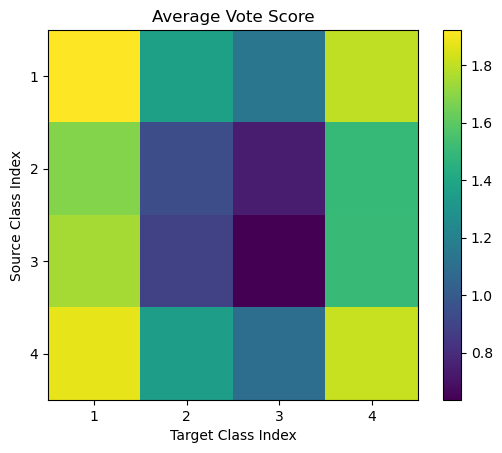

In [47]:
plt.imshow(class_vot.dot([0,1,2])/class_vot.sum(axis=2))
plt.colorbar()
plt.ylabel('Source Class Index')
plt.xticks([0,1,2,3],[1,2,3,4])
plt.xlabel('Target Class Index')
plt.yticks([0,1,2,3],[1,2,3,4])
plt.title('Average Vote Score')